# Universal Healthcare NLP Project

###### This project will explore twitter discussions surrounding the implementation of universal healthcare. The aim will be to create a topic model to display the most common fields of concern for those discussing universal healthcare to better create campaigns and solutions to address any hesitations against it.  

The data will be pulled from twitter using the twint library. Several search queries will be used to pull a wide range of discussion surrounding the topic, including: 
* "universal healthcare"
* "affordable healthcare"
* "healthcare".

This notebook follows the data cleaning process. 
Ultimately, there will be a set of cleaned text data that will be used to create a topic modeling scheme (followed by a sentiment analysis) in a later notebook.

In [1]:
#some libraries
import pandas as pd
import numpy as np


In [2]:
#pull in data
df = pd.read_csv('/Users/mehikapatel/Universal_Healthcare_NLP/Data/FirstTwitterDF')


In [3]:
df.drop(columns = ['urls',
                 'name',
                 'hashtags',
                 'user_id',
                 'user_id_str',
                 'search',
                 'created_at',
                 'conversation_id',
                 'id',
                 'photos',
                 'video',
                 'thumbnail',
                 'link',
                 'cashtags',
                 'quote_url',
                 'Unnamed: 0',
                 'place',
                 'near',
                 'geo',
                 'source',
                 'user_rt_id',
                 'user_rt',
                 'retweet_id',
                 'retweet_date',
                 'translate',
                 'trans_src',
                 'trans_dest',
                  'retweet',
                'nretweets',
                   'nreplies'],inplace=True)

In [4]:
#removing all non english tweets
df = df[df.language == 'en']
#remove the langauge column
df.drop(columns='language',inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 27191
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      26457 non-null  object
 1   timezone  26457 non-null  int64 
 2   tweet     26457 non-null  object
 3   username  26457 non-null  object
 4   day       26457 non-null  int64 
 5   hour      26457 non-null  int64 
 6   nlikes    26457 non-null  int64 
 7   reply_to  26457 non-null  object
dtypes: int64(4), object(4)
memory usage: 1.8+ MB


There are now 26457 tweets left. 

In [6]:
#Base and Cleaning 
import json
import requests
import emoji
import regex
import re
import string
from collections import Counter

# #Visualizations
# import plotly.express as px
# import seaborn as sns
# import matplotlib.pyplot as plt 
# import pyLDAvis.gensim
# import chart_studio
# import chart_studio.plotly as py 
# import chart_studio.tools as tls

#Natural Language Processing (NLP)
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

/Users/mehikapatel/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [7]:
#data cleaning functions

def rid_emojis(text):
    """
    Removes emoji's from tweets
    Accepts:
        Text (tweets)
    Returns:
        Text (emoji free tweets)
    """
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def rid_urls(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    return text

# Apply the function above and get tweets free of emoji's
call_emoji_free = lambda x: rid_emojis(x)

In [8]:
# Apply `call_emoji_free` which calls the function to remove all emoji's
df['emoji_free_tweets'] = df['tweet'].apply(call_emoji_free)

#Create a new column with url free tweets
df['url_free_tweets'] = df['emoji_free_tweets'].apply(rid_urls)

In [9]:
#drop the extra columns and leave only the emoji free and url free texts as the "tweet" column
df.drop(columns=['tweet',
                'emoji_free_tweets'],inplace=True)
df.rename({'url_free_tweets':'tweet'},axis=1,inplace=True)

## Data Preprocessing

- Tokenization
- Words with fewer than 3 characters are removed (unecessary/unmiportant words)
- stopwords are removed
- words are first lemmetized and then stemmed

#### Tokenization

In [10]:
#load spacy 
nlp = spacy.load('en_core_web_lg')

In [11]:
#tokenizer
tokenizer = Tokenizer(nlp.vocab)

# make customized stopwords and add to default list
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

#genism + spacy + wordclou
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)

lower_cased_no_stops = []

for doc in tokenizer.pipe(df['tweet'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            #lower case text and append
            doc_tokens.append(token.text.lower())   
    lower_cased_no_stops.append(doc_tokens)

# Makes tokens column
df['tokens'] = lower_cased_no_stops



In [12]:
# Make tokens a string again
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]

In [13]:
#lemma t function
def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['lemmas'] = df['tokens_back_to_text'].apply(get_lemmas)

In [14]:
# Make lemmas a string again
df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]

In [15]:
# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df['lemma_tokens'] = df['lemmas_back_to_text'].apply(tokenize)

In [16]:
df.head()

,date,timezone,username,day,hour,nlikes,reply_to,tweet,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,2021-05-23 14:22:35,-400,Lyra_evans_ott,7,14,0,[],Lyra on the importance of Medicare and univers...,"[lyra, importance, medicare, universal, health...",lyra importance medicare universal healthcare:...,"[lyra, importance, medicare, universal, health...",lyra importance medicare universal healthcare ...,"[lyra, importance, medicare, universal, health..."
1,2021-05-23 14:21:21,-400,Bowiegrrl1,7,14,0,"[{'screen_name': 'JordanChariton', 'name': 'Jo...",@JordanChariton She was right. People don’t wa...,"[@jordanchariton, right., people, don’t, force...",@jordanchariton right. people don’t forced med...,"[@jordanchariton, right, people, force, medica...",@jordanchariton right people force medicare op...,"[jordanchariton, right, people, force, medicar..."
2,2021-05-23 14:17:58,-400,jenminicooper,7,14,1,"[{'screen_name': 'SenTedCruz', 'name': 'Senato...",@SenTedCruz That’s cool you stand for a countr...,"[@sentedcruz, that’s, cool, stand, country, un...",@sentedcruz that’s cool stand country universa...,"[@sentedcruz, cool, stand, country, universal,...",@sentedcruz cool stand country universal healt...,"[sentedcruz, cool, stand, country, universal, ..."
3,2021-05-23 14:15:09,-400,BlueSteelDC,7,14,4,"[{'screen_name': 'JordanChariton', 'name': 'Jo...",@JordanChariton Hillary Clinton was 100% ride ...,"[@jordanchariton, hillary, clinton, 100%, ride...",@jordanchariton hillary clinton 100% ride medi...,"[@jordanchariton, hillary, clinton, 100, ride,...",@jordanchariton hillary clinton 100 ride medic...,"[jordanchariton, hillary, clinton, 100, ride, ..."
4,2021-05-23 14:13:02,-400,colonthatsme,7,14,1,[],thinking about that guy who was like “if you h...,"[thinking, guy, “if, pick, one,, pick, univers...","thinking guy “if pick one, pick universal heal...","[think, guy, pick, pick, universal, healthcare...",think guy pick pick universal healthcare gay s...,"[think, guy, pick, pick, universal, healthcare..."


In [178]:
#save the new dataframe to pull into a new notebook for topic modeling
df.to_csv(r'/Users/mehikapatel/Universal_Healthcare_NLP/Data/SecondTwitterDF')

In [35]:
all_words = [word for tokens in df['tweet'] for word in tokens]
tweet_lengths = [len(tokens) for tokens in df['tweet']]
vocab = sorted(list(set(all_words)))

print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))
print('Min tweet length is {}'.format(min(tweet_lengths)))

5421810 words total, with a vocabulary size of 925
Max tweet length is 964
Min tweet length is 4


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/mehikapatel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


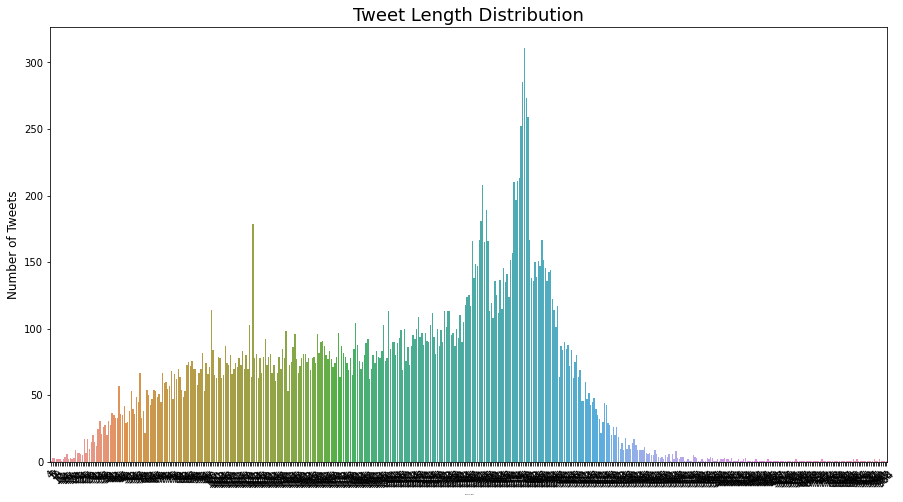

In [45]:
plt.figure(figsize = (15,8))
ax = sns.countplot(tweet_lengths)

plt.title('Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = .2)
plt.xticks(rotation=45)
# ax.set_xlim(5, 900)
# ax.set_xticks(range(5,1000,50))
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

In [49]:
from nltk.probability import FreqDist

#iterate through each tweet, then each token in each tweet, and store in one list
flat_words = [item for sublist in df['lemma_tokens'] for item in sublist]

word_freq = FreqDist(flat_words)

word_freq.most_common(30)

[('healthcare', 27684),
 ('affordable', 9710),
 ('universal', 9659),
 ('people', 3762),
 ('need', 2987),
 ('good', 2690),
 ('care', 2619),
 ('health', 2589),
 ('pay', 2576),
 ('education', 2359),
 ('free', 2258),
 ('wage', 2149),
 ('country', 2088),
 ('system', 2074),
 ('right', 1965),
 ('work', 1900),
 ('job', 1818),
 ('access', 1782),
 ('american', 1662),
 ('housing', 1552),
 ('support', 1467),
 ('life', 1365),
 ('thing', 1338),
 ('quality', 1338),
 ('insurance', 1289),
 ('provide', 1246),
 ('think', 1210),
 ('help', 1174),
 ('year', 1145),
 ('well', 1144)]

We see the following are the 28 most popular words in the tweets (outside of "healthcare","affordable", "universal",which were in our original search query):

* people, need, good, care, health, pay, education, free, wage, country, system, right, work, job, access, american, housing, support, life, thing, quality, insurance, provide, think, help, year, well

Let's create a wordcloud:

In [55]:
#get words n count w touples
most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#dict mapping of words
top_28_dictionary = dict(zip(most_common_word, most_common_count))

#remove healthcare, affordable, and universal from dict
del top_28_dictionary['healthcare']
del top_28_dictionary['affordable']
del top_28_dictionary['universal']


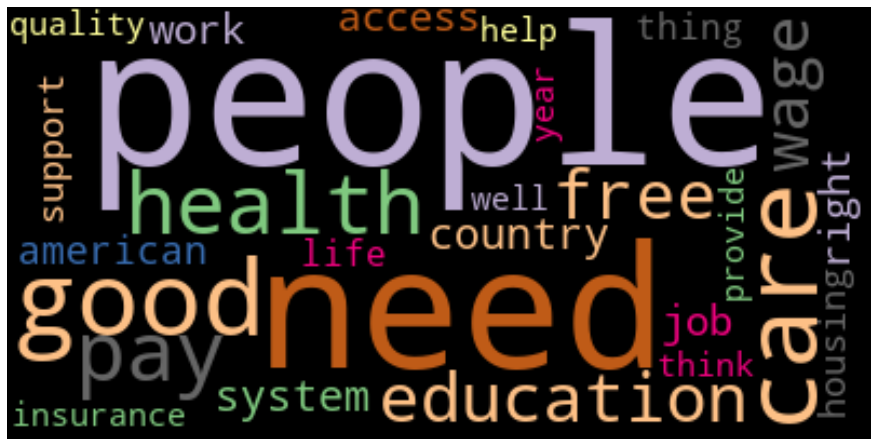

In [56]:
from wordcloud import WordCloud

#make wordcloud
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_28_dictionary)

#plot 
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('top_30_cloud.png')

plt.show()